# Q1:Finding Similar Costumers using Local Sensitivity Hashing

## Q1.1 Processing of the Banking Dataset

### Required Libraries

In [165]:
import pandas as pd
import datetime
from datetime import datetime
from tqdm import tqdm as tq
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
import collections
import itertools
import re
from datetime import date
from datetime import datetime
import heapq
from heapq import *
import seaborn as sns

In [72]:
dataset=pd.read_csv('bank_transactions.csv') ###Reading the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


### Drop NaN Rowsdataset
> Since the number of rows with mising Values is very small, we decide to drop the NaN rows.

In [73]:
dataset.dropna(inplace=True)

### Customer DOB

In [74]:
dataset['CustomerDOB']=pd.to_datetime(dataset.CustomerDOB,dayfirst=True)##Converting DOB to datetime object

In [75]:
## While converting to DOB dates,some DOB are incorrectly transformed. Hence we correct those dates which have birth of year
## greater than 2000 (reasoning based on the fact the customers cannot be minors)
dataset.loc[dataset.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = dataset.loc[dataset.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [76]:

### Replacing people with DOB as 1800 to mode DOB(Replacing incorrect DOB)
mode_year=dataset[dataset.CustomerDOB.dt.year!=1800].CustomerDOB.mode()

dataset.loc[dataset.CustomerDOB.dt.year==1800,'CustomerDOB']=list(mode_year.values)[0]

## Transaction Date

In [85]:
dataset.TransactionDate=pd.to_datetime(dataset.TransactionDate,dayfirst=True) ##Converting Transaction dates to datetime object

### Create New ID for Customers:
>To deal with the cases for those account which has same customer ID but different people belong to those accounts, hence we propose to use new Customer ID made of old Customer Id and their Age.

> To deal with the cases for those accounts with different customer ID with same DOB,Gender,Account Balance(quite common).

> This is done with the view that through the Implementation of LSH we don't for a query to get results such they results have exact matching values for the query.If we want to find duplicates,we can just use Pandas methods to find duplicate's.

In [78]:
# dataset["ID"]=dataset.CustomerID + dataset.AGE.apply(lambda row:str(int(row)))+dataset.CustGender
## New Customer ID is based on Customers DOB,Gender and Account Balance(We find all the unique triplets of these combinations.)
ID = {}
j = 0
### Iterating over the dataset
for i, row in dataset.iterrows():
    ### Storing all the unique combinations of the triplets.
    if (row['CustomerDOB'], row['CustGender'], row['CustAccountBalance']) not in ID:
        ID[row['CustomerDOB'], row['CustGender'], row['CustAccountBalance']] = j
        j += 1
### Assigning the ID's to the customers
dataset['ID'] = dataset.apply(lambda x: ID[x['CustomerDOB'], x['CustGender'], x['CustAccountBalance']], axis=1)
dataset['ID'] = dataset['ID'].astype(int)


### Important Feature Extraction 

## Age of Customer
> We use DOB to find the age of the customers.The age is calculate with reference to 31st December,2016.(Feature Engineering)

In [77]:

dataset["AGE"]=((datetime(2016,12,31)-dataset.CustomerDOB)/np.timedelta64(1, "Y")).round(0)


In [87]:
def time_interval_transaction(series):
    """"
    input:series:Pandas series object
    objective: It calculates the average day in the year when usually the customer does his transactions.For each transaction of
    the customer time-difference(in days) between his transaction date and 1st January,2016 is calculated.Further we compute the
    average of all the transactions.

    return:Float
    
    """""
    
    days=[]
    for i in series:
       
        delta=i-datetime(2016,1,1,0,0,0)
        days.append(delta.days)
    return sum(days)/len(days)

### Finalising the features to compute similarity:

> We decide to use Customers Age,Account Balance,Transaction Amount and Transaction Dates to find customers with similar behaviour.

In [138]:

### Reducing the dataset on their New Customer-ID and aggregating the infomration for the customers
df_reduced=dataset.groupby('ID').agg({'AGE':['first'],'CustAccountBalance':['mean'],\
                                       'TransactionAmount (INR)':['mean'],'TransactionDate':[time_interval_transaction]})

df_reduced.columns=df_reduced.columns.droplevel(1)

df_reduced.rename(columns={'TransactionDate':'Trans_interval'},inplace=True)


In [139]:
df_reduced

,AGE,CustAccountBalance,TransactionAmount (INR),Trans_interval
ID,,,,
0,23.0,17819.05,80.111111,237.000000
1,60.0,2270.69,9503.445000,227.000000
2,20.0,17874.44,940.348182,237.181818
3,43.0,866503.21,2537.346923,244.615385
4,29.0,6714.43,1606.135000,214.000000
...,...,...,...,...
170785,26.0,218207.57,726.800000,261.000000
170786,35.0,182889.37,600.000000,261.000000
170787,24.0,15037.89,220.000000,261.000000


## Q1.2 Fingerprint Hashing

> Since the features that we are targeting have very large number of unique values(Especially transaction amount,Customer Account Balance). 

> So the idea to consider the all the unique values for all the features will give us constraint regarding memmory space.Further to elaborate, a person spending 50INR and 100 INR would be similar for the bank. 

>Hence we decide to bin the features and their respective bins would be their set of unique shingles. 

## Binning Features

In [91]:
def label_bin(row,bins):
    """"
    input:row:Pandas series object
          bins:The different bins for the feature
    objective:It calculates the bins position for a custoemr based on it's repsective features values
    returns:The bin index
    
    """""
    
    x=np.where(bins<=row)[0][-1]+1
    
    if x<len(bins):
        return x
    else:
        return x-1



In [18]:
# def label_categorical(row):
#     if (row=='M') or (row=='T') :  ### There is one row in dataset as Gender =T we assume it's male
#         return 1
#     else:
#         return 2

In [140]:
features=[] ### Contains the name of all the features bins  generated
bins=[] ### Contains the bins values used for each feature

## Dividing age into 10 bins
counts,division=pd.np.histogram(df_reduced.AGE,bins=10)
bins.append(division)
## Getting the bins for the customer based on it's Age
df_reduced['Age_bin']=df_reduced.AGE.apply(lambda row:label_bin(row,division))
features.append(['bin_A'+str(i+1) for i in range(len(division)-1)])
print('Binning Age Finished')

Binning Age Finished


<AxesSubplot:xlabel='Count', ylabel='AGE'>

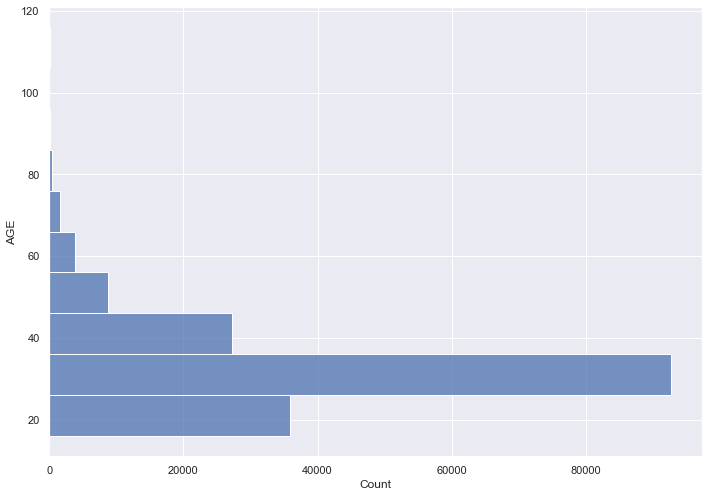

In [98]:
sns.histplot(bins=bins[0],y=df_reduced.AGE) ### Histogram representing  number of values in each bin

In [141]:
## Dividing Customer Account Balance into 45 bins

## The goal is to have a high number of bins so that the probability that multiple customer falls into a bin is low

bins_c=[list(np.linspace(0,1000,5))+list(np.linspace(3000,10000,4))+list(np.linspace(10000,100000,10))+list(np.linspace(100000,1000000,10))+\
      list(np.linspace(1000000,10000000,10))+list(np.linspace(10000000,max(df_reduced.CustAccountBalance),10))]

bins_c=list(set(bins_c[0]))
bins_c.sort()
bins.append(bins_c)
## Getting the bins for the customer based on it's account balance
counts,division=pd.np.histogram(df_reduced.CustAccountBalance,bins=bins_c)
features.append(['bin_b'+str(i+1) for i in range(len(bins_c)-1)])
df_reduced['Balance_bin']=df_reduced.CustAccountBalance.apply(lambda row:label_bin(row,division))

print('Binning Customer Balance Finished')


Binning Customer Balance Finished


<AxesSubplot:>

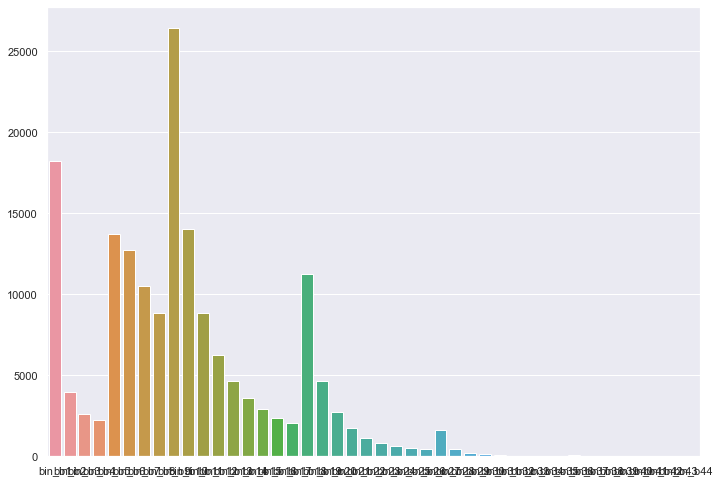

In [113]:
sns.barplot(x=features[1],y=counts)### Barplot representing  number of values in each bin

In [115]:
max(counts)/len(df_reduced) ## In worst case the max probability that two customer would share the same bin

0.1547982902980268

In [142]:
#Dividing Customer Transaction Amount to 25 bins

bins_c=[list(np.linspace(0,1000,5))+list(np.linspace(1000,10000,5))+list(np.linspace(10000,100000,10))+list(np.linspace(100000,800000,8))]

bins_c=list(set(bins_c[0]))
bins_c.sort()
bins.append(bins_c)
counts,division=pd.np.histogram(df_reduced['TransactionAmount (INR)'],bins=bins_c)
df_reduced['Transaction_bin']=df_reduced['TransactionAmount (INR)'].apply(lambda row:label_bin(row,division))
features.append(['bin_T'+str(i+1) for i in range(len(bins_c)-1)])

print('Binning Transaction Amount Finished')


Binning Transaction Amount Finished


<AxesSubplot:>

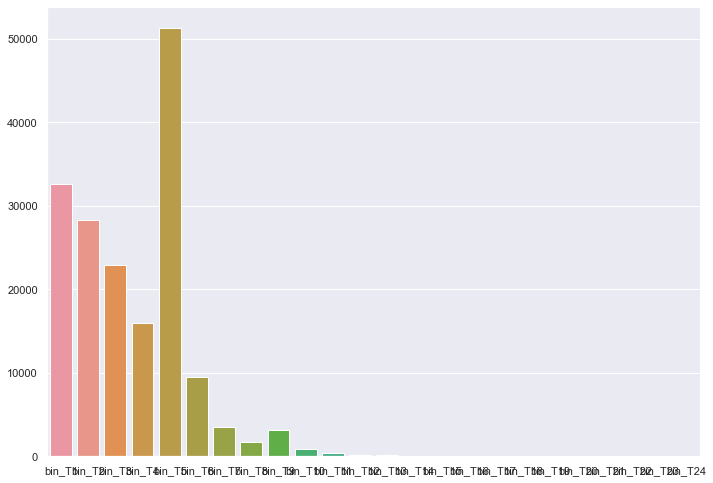

In [124]:
sns.barplot(x=features[2],y=counts) ### Barplot representing  number of values in each bin

In [143]:

# Dividing Interval between transactions into 24bins
counts,division=pd.np.histogram(df_reduced.Trans_interval,bins=24)
df_reduced['Trans_interval_bin']=df_reduced.Trans_interval.apply(lambda row:label_bin(row,division))
bins.append(division)
features.append(['bin_TI'+str(i+1) for i in range(len(division)-1)])
print('Binning Average day of the year for transaction Finished')



Binning Average day of the year for transaction Finished


<AxesSubplot:>

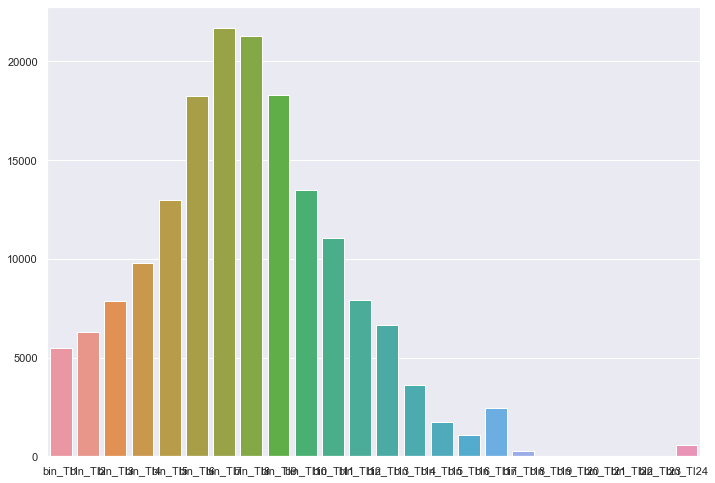

In [127]:
sns.barplot(x=features[3],y=counts) ### Barplot representing  number of values in each bin

In [144]:
df_reduced=df_reduced.reset_index()
df_reduced.drop(['ID'],axis=1,inplace=True)
df_reduced

,AGE,CustAccountBalance,TransactionAmount (INR),Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin
0,23.0,17819.05,80.111111,237.000000,1,9,1,8
1,60.0,2270.69,9503.445000,227.000000,5,5,8,5
2,20.0,17874.44,940.348182,237.181818,1,9,4,8
3,43.0,866503.21,2537.346923,244.615385,3,25,5,10
4,29.0,6714.43,1606.135000,214.000000,2,7,5,1
...,...,...,...,...,...,...,...,...
170785,26.0,218207.57,726.800000,261.000000,2,19,3,15
170786,35.0,182889.37,600.000000,261.000000,2,18,3,15
170787,24.0,15037.89,220.000000,261.000000,1,9,1,15
170788,29.0,1002.96,1146.650000,261.000000,2,5,5,15


## Going for Min Hash 

> Now we have the representation for all the shingles possible for the Customers. We get 102 possible shingles for a cusomter.We understand the number of shingles are quite low,theortically we should have very high possible shingle.

> Our decision is based on the fact that increasing more bins for the features limits the possibility of finding similar customer. For example a customer spending 10000INR is same for the bank(in behaviour-wise) as someone who spends 10500 INR.

>Next we go for creating the one-hot representation for the dataset.

> Further, we implement Min hash from the one-hot dataset.

## Creating One-Hot Matrix from the dataset

In [154]:
def one_hot(df_reduced,features):
    """"
    input:df_reduced:Pandas Dataframe
          feaures:A list,individual element is also a list which contains all the bins for respective feature.
    objective:It computes one-hot array based on binned values of the features for the customers
    returns:Numpy array: One-hot matrix
    
    """""
    
    num_features=0
    
    ## Getting total number of features
    for i in features:
        num_features+=len(i)
    
    ## allocating the space for the one-hot matrix with size: (Number of Customers, Number of features)
    final_matrix=np.zeros((len(df_reduced),num_features))
    
    ## Based on the bin value for the features the index for the 1's is calulcated 
    for _,i in tq(enumerate(df_reduced.iterrows())):
        
        final_matrix[i[0],int(i[1]['Age_bin'])-1]=1
        final_matrix[i[0],int(i[1]['Balance_bin'])-1+len(features[0])]=1
        final_matrix[i[0],int(i[1]['Transaction_bin'])-1+len(features[0])+len(features[1])]=1
        final_matrix[i[0],int(i[1]['Trans_interval_bin'])-1+len(features[0])+len(features[1])+len(features[2])]=1

        
    return final_matrix
        
        
        

In [155]:
cust_matrix=one_hot(df_reduced,features)
cust_matrix.shape

170790it [00:06, 27453.94it/s]


(170790, 102)

## Signature matrix

> The main idea behind signature matrix is that reodering the features should not effect the similarity between similar entities(here customers)

> It helps in reducing the size of the represetations of the entities(dimensionality reduction). 

> This combined with permutations help us to narrow down the search for possible similar candidates for a query and this reduces the computation in a very effective way.

In [156]:
def signature_matrix(perm:int,customer_matrix):
    """"
    input:perm:Integer,Number of permuations
          Customer_matrix:Numpy array,One-hot representation of the dataset
    objective:It computes the Signatures matrix for the customer based on the one-hot matrix of the customers.For each permutations
              the order of the features for all the customer are shuffled and then we retreive the position of first occurence of
              1.
    returns:Numpy array: Signature-Matrix
    
    """""
    
    
    ##Seeting seed for replicability in permutations
    np.random.seed(123)
    
    sig_matrix=np.zeros((customer_matrix.shape[0],perm))
    for i in tq(range(perm)):
        ## Get index of the features
        idx=np.arange(customer_matrix.shape[1])
        ## Shuffle the index
        np.random.shuffle(idx)
        ## Shuffle the customer_matrix
        customer_matrix=customer_matrix[:,idx]
        ## get positions of 1s
        one_pos=np.argwhere(customer_matrix==1)
        ##create counter to get first position of 1 for each document
        counter=0
        for j,k in enumerate(one_pos):
            ## identify the position of first one for jth document
            if k[0]==counter:
                sig_matrix[counter,i]=k[1]+1
                counter +=1
    return sig_matrix
                

In [157]:
## Going for 80 permuations and creating the signature matrix
sig_matrix=signature_matrix(80,cust_matrix)


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:30<00:00,  2.66it/s]


In [27]:
sig_matrix.shape

(170790, 80)

## Q1.3 Locality Sensitive Hashing

> Now we have obtained are signature matrix based on our dataset. Then we go for splitting the signature matrix into different bands.Number of bands should be choosen carefully,using higher bands leads to high number of False Positive and low number of bands leads to High False Negative.

>We experiment for two possible choices of Bands=40,20

> Once we divide our signature matrix into bands we hash the bands into different buckets. The main idea is that Customer's who have same value in a bands are potential similar candidate's. Hence if the customer have same values in the same band they would go in the same bucket. 

>We use different hash functions for different bands. Note:We don't use hash funcions explicitly but instead use a similar way to mimic the behviour of hash function.

### Now we go for hashing the bands to put them into buckets.Let's go for number of bands as 40 bands and 2 rows per each band

In [184]:
def Candidate_Pairs(sig_matrix,b):
    """"
    input:sig_matrix:Numpy array: The signature matrix
          b:Integer,Number of Bands
    objective:It computes the different buckets for individuals bands. So for each band based on the columns values(feature) for 
              each customer they go into buckets.The customer will share the bucket which have same columns values for that band.
              SO in this way club together those customer with similar behaviour.
    returns:Dict: Buckets
    
    """""
    
    
    n_cust,sig_dim=sig_matrix.shape
    try:
        assert(sig_dim%b==0)
    except:
        print('The Length of signature matric should be divisible ')
    ##Intialisig a deafult dict
    buckets=collections.defaultdict(set)
    
    ## Splitting the signature matrix
    bands=np.array_split(sig_matrix,b,axis=1)
    
    ##Iterating over bands
    for i,band in tq(enumerate(bands)):
        ### Iterating over customers to find their bucket 
        for  j in range(n_cust):
            
            ### Bucket key is made of tuple of values in particulAr column and index of band(which is a string object of the 
            ### band index. In this way we avoid collision of same set of values in different bands analogous to using different
            ### hash function for different bands)
            idx=tuple(list(band[j,:])+[str(i)])
            
            ### adding the document based on it's key(refer above) and value(customer index)
            buckets[idx].add(j)
    return buckets
            

In [159]:
buckets=Candidate_Pairs(sig_matrix,40)

40it [00:12,  3.16it/s]


## Querying most similar Customers based on the query data
> Now we have finished putting the customers in Dataset in buckets which form the potential similar customers.

> Then we go for finding the similar customer's for our query. We follow the similar process that we did previously for the main dataset.

>>#### We preprocess the query features into repsective bins.
>>#### We create the one-hot matrix for the query.
>>#### Then we find the signature matrix.
>>#### Based on the signature matrix we find the buckets that query hash into.
>>#### Then we use these buckets to find similar customer's and compute similarity for each query. So instead of computing the similarity between all the customers and the query,using this approach we compute similarity between very less pair's of combinations.

In [163]:
query=pd.read_csv('query_users.csv')

## Processing Features
query['CustomerDOB']=pd.to_datetime(query.CustomerDOB)
query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
query.loc[query.CustomerDOB.dt.year==1800,'CustomerDOB']=list(mode_year.values)[0]
query.TransactionDate=pd.to_datetime(query.TransactionDate,dayfirst=True)
query["AGE"]=((datetime(2016,12,31)-query.CustomerDOB)/np.timedelta64(1, "Y")).round(0)
query['Trans_interval']=query.TransactionDate.apply(lambda row:(row-datetime(2016,1,1,0,0,0)).days)

## Putting the features to their bin
query['Age_bin']=query.AGE.apply(lambda row:label_bin(row,np.array(bins[0])))
query['Balance_bin']=query.CustAccountBalance.apply(lambda row:label_bin(row,np.array(bins[1])))
query['Transaction_bin']=query['TransactionAmount (INR)'].apply(lambda row:label_bin(row,np.array(bins[2])))
query['Trans_interval_bin']=query.Trans_interval.apply(lambda row:label_bin(row,np.array(bins[3])))

query.drop(['CustomerDOB','CustGender','CustLocation','TransactionDate','TransactionTime'],axis=1,inplace=True)
query

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin
0,94695.61,65.00,38.0,245,3,17,1,10
1,7584.09,6025.00,25.0,245,1,7,7,10
2,7180.60,541.50,25.0,222,1,7,3,3
3,56847.75,1000.00,30.0,241,2,13,5,9
4,84950.13,80.00,22.0,268,1,16,1,17
5,23143.95,303.00,35.0,254,2,10,2,13
6,15397.80,20.00,40.0,240,3,9,1,9
7,426.30,50.00,25.0,214,1,2,1,1
8,4609.34,300.00,27.0,238,2,6,2,8
9,6695988.46,299.00,46.0,239,4,32,2,8


### One-hot representations of the query dataset

In [54]:
query_matrix=one_hot(query,features)
query_matrix.shape

(50, 102)

### Computing the Signature matrix of the query 

In [32]:
query_sig_matrix=signature_matrix(80,query_matrix)

100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 7302.38it/s]


### Metrics for similarity:

> We will be using Jaccard Similairty to compute similarity between potential Candidate pair(those customers who share the buckets with the query ).



In [164]:


def Jaccard_score(a,b):
    
    a=np.argwhere(a!=0)
    b=np.argwhere(b!=0)
    
    return sum(a==b)/(sum(a==b)+2*sum(a!=b))

In [62]:


def Query_LSH(query_sig_matrix,buckets,cust_matrix,thresh,bands):
    """"
    input:query_sig_matrix:Numpy array: The signature matrix based on our query
          buckets:Dict:The buckets obtained from hashing the dataset
          cust_sig_matrix:Numpy array: The signature matrix based on our dataset
          thresh:float:Threshold
          bands:Integer,Number of Bands
    objective:It computes the top-3 similar customers for each query whose similarity exceeds the threshold
    returns:result:Dict:For each query(key) we have the documents id's(value) of top-3 similar customer
            fp:Dict:For each query(key) we have the list of document id's(value) whose similarity was less than the threshold
    """""
    
    ##Storing Results:
    result={}
    ##False positives
    fp={}
    #threshold
    th=thresh
    for idx in tq(range(query_sig_matrix.shape[0])):

        ## Hashing the query bands to it's bucket
        query_buckets=Candidate_Pairs(query_sig_matrix[idx,:].reshape(1,-1),bands)

        ## Scoring Metric
        score=[]

        ## Converting List of score to heap data-structure
        heapq.heapify(score)

        ## Keeping tranks of documents that have been considered for similairity calculations to avoid multiple calculation for same 
        ## customer
        customer_list=[]

        ##Max_length
        max_length=3

        ##False_positives:
        FP=[]

        for count,i in enumerate(query_buckets):


            ## Checking if the bucket is present in buckets retrieved from the customers
            if i in list(buckets.keys()):

                ## Iterating over the customers found in matched bucket
                for j in buckets[i]:

                    if j not in customer_list:
                        #Computing Jaccard Similarity for each candidate pairs using their query and dataset one-hot matrix
                        similarity=Jaccard_score(query_matrix[idx,:],cust_matrix[j,:])
                        if similarity>=th:

                            if max_length>0:
                                #individual elment in heap is (jaccard score,document_id)
                                heappush(score,(similarity,j))
                                customer_list.append(j)
                                max_length-=1

                            else:
                                #replace the minimum of heap if the score is higher
                                if similarity>score[0][0]:
                                    heapreplace(score,(similarity,j))
                                    customer_list.append(j)
                        else:
                            ##False positives
                            FP.append(j)

        result[idx]=heapq.nlargest(3,score)
        fp[idx]=len(FP)
    return result,fp     

### For fixed number of bands we try Experiment different threshold value.
> Threshold controls the number of False positive(and False negative too). Let's see the results for threshold =0.7

In [167]:
result,fp=Query_LSH(query_sig_matrix,buckets,cust_matrix,0.7,40)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
40it [00:00, ?it/s][A
  2%|█▋                                                                                 | 1/50 [00:02<02:00,  2.46s/it]
40it [00:00, 39643.71it/s]
  4%|███▎                                                                               | 2/50 [00:03<01:27,  1.82s/it]
40it [00:00, 40860.24it/s]
  6%|████▉                                                                              | 3/50 [00:06<01:39,  2.13s/it]
40it [00:00, 40098.51it/s]
  8%|██████▋                                                                            | 4/50 [00:12<02:56,  3.84s/it]
40it [00:00, ?it/s][A
 10%|████████▎                                                                          | 5/50 [00:16<02:46,  3.71s/it]
40it [00:00, 39869.81it/s]
 12%|█████████▉                                                                         | 6/50 [00:19<02:36,  3.56s/it]
40it [00

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

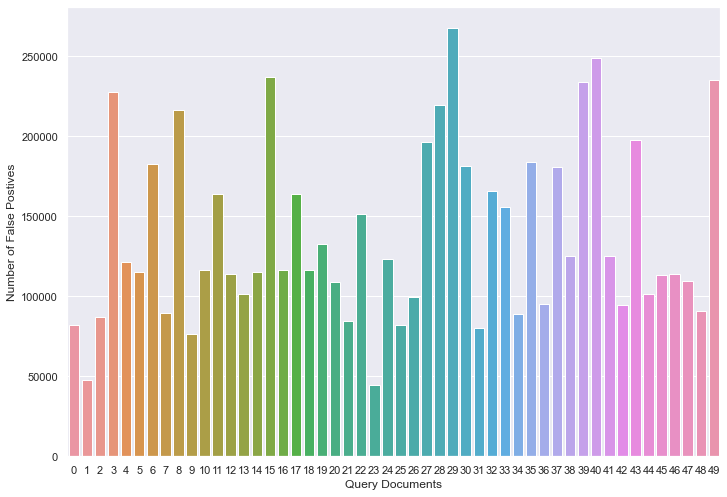

In [190]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp.keys()),y=list(fp.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [177]:
score=[]
for i in result:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
102942,5993.34,606.900000,22.0,222.000000,1.0,7.0,3.0,3.0,[1.0]
79895,6763.42,525.000000,24.0,220.500000,1.0,7.0,3.0,3.0,[1.0]
61584,5615.66,618.000000,18.0,221.500000,1.0,7.0,3.0,3.0,[1.0]
3,56847.75,1000.000000,30.0,241.000000,2.0,13.0,5.0,9.0,Query
131727,55659.20,2010.614000,35.0,243.200000,2.0,13.0,5.0,9.0,[1.0]
33101,58026.99,2950.111111,29.0,241.555556,2.0,13.0,5.0,9.0,[1.0]


#### First from the barplot,we notice to have a high number of False positives.

#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

> For some query we do not get any similar customers whose similarrity are greater than the threshold.

> For some query we get most similar customers in number less than 3.

In [56]:
result_1,fp_1=Query_LSH(query_sig_matrix,buckets,cust_matrix,0.6,40)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
40it [00:00, ?it/s][A
  2%|█▋                                                                                 | 1/50 [00:02<01:58,  2.41s/it]
40it [00:00, ?it/s][A
  4%|███▎                                                                               | 2/50 [00:03<01:26,  1.80s/it]
40it [00:00, ?it/s][A
  6%|████▉                                                                              | 3/50 [00:06<01:41,  2.16s/it]
40it [00:00, ?it/s][A
  8%|██████▋                                                                            | 4/50 [00:13<03:03,  3.99s/it]
40it [00:00, ?it/s][A
 10%|████████▎                                                                          | 5/50 [00:16<02:54,  3.88s/it]
40it [00:00, ?it/s][A
 12%|█████████▉                                                                         | 6/50 [00:20<02:47,  3.80s/it]
40it [00:00, ?it/s][A
 14%|█

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

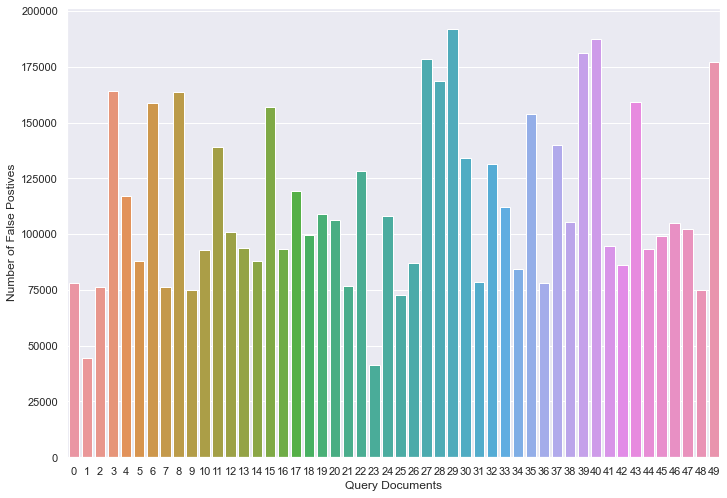

In [189]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp_1.keys()),y=list(fp_1.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [176]:
score=[]
for i in result_1:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result_1[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
120322,82.19,163.666667,44.0,245.000000,3.0,1.0,1.0,10.0,[0.6]
28674,8852.34,194.000000,39.0,243.400000,3.0,8.0,1.0,10.0,[0.6]
17911,3798.36,240.521739,36.0,243.608696,3.0,6.0,1.0,10.0,[0.6]
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
149522,5468.46,346.000000,23.0,245.000000,1.0,7.0,2.0,10.0,[0.6]
143415,4.26,5696.740000,22.0,244.000000,1.0,1.0,7.0,10.0,[0.6]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
102942,5993.34,606.900000,22.0,222.000000,1.0,7.0,3.0,3.0,[1.0]


#### First from the barplot,we notice to have a high number of False positives but these number are smaller than previous case.(that is what we expected with weaker constraint)

#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

>In this case we notice for every query we got top-3 customers which have similarity greater than the threshold.

In [63]:
buckets_1=Candidate_Pairs(sig_matrix,20)
result_2,fp_2=Query_LSH(query_sig_matrix,buckets_1,cust_matrix,0.7,20)


20it [00:05,  3.60it/s]
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]
20it [00:00, 19831.22it/s]
  2%|█▋                                                                                 | 1/50 [00:00<00:09,  5.25it/s]
20it [00:00, ?it/s][A
  4%|███▎                                                                               | 2/50 [00:00<00:09,  5.28it/s]
20it [00:00, ?it/s][A
  6%|████▉                                                                              | 3/50 [00:00<00:09,  4.76it/s]
20it [00:00, ?it/s][A
  8%|██████▋                                                                            | 4/50 [00:01<00:27,  1.69it/s]
20it [00:00, ?it/s][A
 10%|████████▎                                                                          | 5/50 [00:01<00:19,  2.30it/s]
20it [00:00, ?it/s][A
 12%|█████████▉                                                                         | 6/50 [00:02<00:17,  2.56it/s]

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

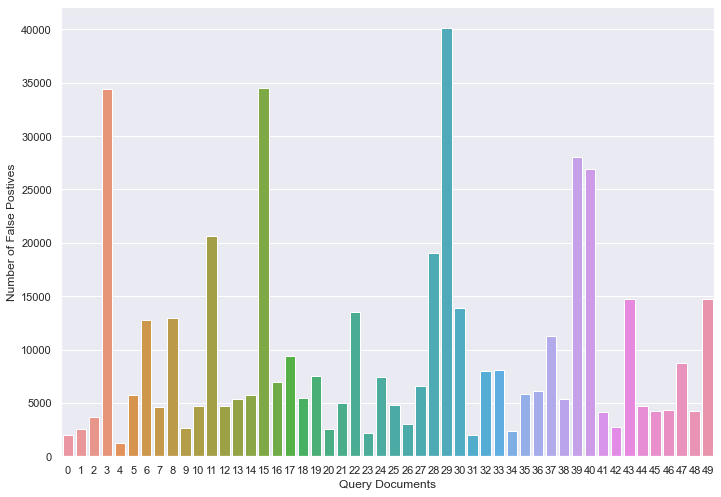

In [187]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp_2.keys()),y=list(fp_2.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [178]:
score=[]
for i in result_2:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result_2[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
80648,6956.46,602.000000,24.0,223.000000,1.0,7.0,3.0,3.0,[1.0]
65297,5942.23,684.500000,24.0,221.500000,1.0,7.0,3.0,3.0,[1.0]
61584,5615.66,618.000000,18.0,221.500000,1.0,7.0,3.0,3.0,[1.0]
3,56847.75,1000.000000,30.0,241.000000,2.0,13.0,5.0,9.0,Query
145427,51010.56,1200.000000,33.0,242.000000,2.0,13.0,5.0,9.0,[1.0]
145414,57166.86,1948.880000,28.0,243.000000,2.0,13.0,5.0,9.0,[1.0]


#### First from the barplot,we notice to have  appreciably reduce the number of False positives compared to the case where number of bands were 40.
#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

>In this case we notice for every query we got top-3 customers which have similarity greater than the threshold.


In [195]:
result_3,fp_3=Query_LSH(query_sig_matrix,buckets_1,cust_matrix,0.6,20)

[Text(0, 0.5, 'Number of False Postives'), Text(0.5, 0, 'Query Documents')]

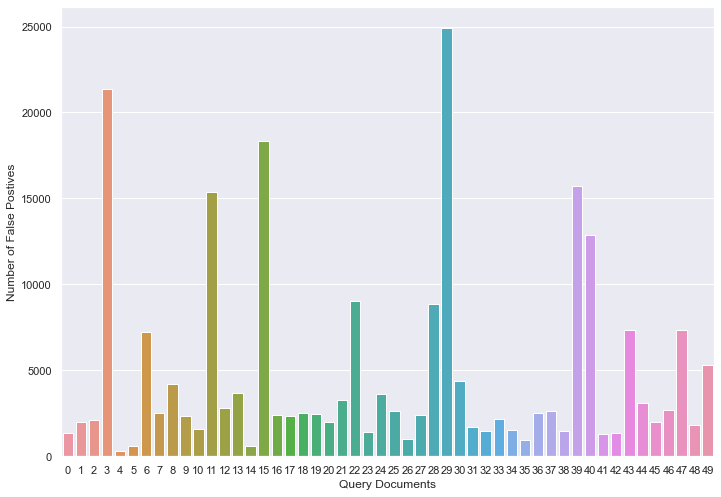

In [188]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
g=sns.barplot(x=list(fp_3.keys()),y=list(fp_3.values()))
g.set(ylabel='Number of False Postives', xlabel='Query Documents')

In [183]:
score=[]
for i in result_3:
   
    if i==0:
        df=pd.DataFrame(query.loc[i])
        score.append('Query')
    else:
        df=pd.concat([df,query.loc[i]],axis=1)
        score.append('Query')
    for j in result_3[i]:

        df=pd.concat([df,df_reduced.loc[j[1]]],axis=1)
        score.append(j[0])
df=df.T
df["Score"]=score
df.head(20)

,CustAccountBalance,TransactionAmount (INR),AGE,Trans_interval,Age_bin,Balance_bin,Transaction_bin,Trans_interval_bin,Score
0,94695.61,65.000000,38.0,245.000000,3.0,17.0,1.0,10.0,Query
147333,8218.37,100.000000,36.0,246.000000,3.0,8.0,1.0,10.0,[0.6]
146702,8392.99,106.000000,36.0,245.000000,3.0,8.0,1.0,10.0,[0.6]
28674,8852.34,194.000000,39.0,243.400000,3.0,8.0,1.0,10.0,[0.6]
1,7584.09,6025.000000,25.0,245.000000,1.0,7.0,7.0,10.0,Query
149232,5646.89,7000.000000,24.0,245.000000,1.0,7.0,7.0,10.0,[1.0]
35918,5629.43,6999.000000,23.0,215.000000,1.0,7.0,7.0,1.0,[0.6]
27137,7010.72,6839.000000,24.0,267.500000,1.0,7.0,7.0,17.0,[0.6]
2,7180.60,541.500000,25.0,222.000000,1.0,7.0,3.0,3.0,Query
80648,6956.46,602.000000,24.0,223.000000,1.0,7.0,3.0,3.0,[1.0]


#### First from the barplot,we notice to have  appreciably reduce the number of False positives compared to the case where number of bands were 40.
#### In the above dataframe ,Query is identified by 'Query' in score column which is followed by top-3 most similar results.

> For some query we do not get any similar customers whose similarity are greater than the threshold.

> For some query(just two) we get most similar customers in number less than 3.

### Final Comments and Observation:

> Computationally, we noticed that if we go for lower number of bands, it more time-efficient(as it has less hashing operations
to perform on the signature matrix).

> Using higher number of bands increase the number of False Positives which in turn increase the number of candidate pairs for calculations of Similarity.

> We notice that using two different bands combinations does not affect the performance of finding the similar customers. We get customers with same similarity score in both the case for individual query. 

> Since we have used four type of features to compute the similarity(quite sensitive),picking appropriate threshold is quite important to get results for each query. (which also depends on the objective of the task)


## Q2: Clustering Analysis on the Banking Dataset

## 2.1 Getting your data + feature engineering

## Required Libraries

In [158]:
#import required libraries
import pandas as pd
import datetime
from datetime import datetime, date
from tqdm import tqdm as tq
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import random
import collections
import itertools
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
# !pip install bkmeans
from bkmeans import BKMeans

import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score as db
from sklearn import metrics

import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark import SQLContext
from pyspark.sql import SparkSession
import math

In [2]:
#import data and check them
data=pd.read_csv('bank_transactions.csv')
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


## Data cleaning

### Handle NaN

In [3]:
#drop NaN rows to avoid having customers without some information
data.dropna(inplace=True)

### Handle Customer DOB

In [4]:
#convert date of birth to datetime object
data['CustomerDOB']=pd.to_datetime(data.CustomerDOB, dayfirst=True)

In [5]:
#treat customers with date of birth greater than 2000
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [6]:
# Replace people with DOB as 1800 to mode DOB, since we suppose the dates are incorrect
mode_year=data[data.CustomerDOB.dt.year!=1800].CustomerDOB.mode()
data.loc[data.CustomerDOB.dt.year==1800,'CustomerDOB']=list(mode_year.values)[0]

### Handle Transaction Date

In [7]:
#convert transaction date column to datetime object
data.TransactionDate=pd.to_datetime(data.TransactionDate,dayfirst=True)

### Derive the Age of Customers

In [8]:
#compute the age for each customer ID to have a more relevant information frome tha date of birth
data["AGE"]=((datetime(2016,12,31)-data.CustomerDOB)/np.timedelta64(1, "Y")).astype(int)


In [9]:
data


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),AGE
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,22
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,59
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,20
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,43
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,28
...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,NEW DELHI,7635.19,2016-09-18,184824,799.0,26
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,183734,460.0,24
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,183313,770.0,27
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.0,38


### Transaction Time

In [10]:
#convert transaction time to datetime
data.TransactionTime=data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
#this will create also a date that will be not correspondent to transaction date but since it will be the same for each customer it will not cause issues

In [11]:
#rename the column TransactionAmount(INR) with only TransactionAmount only for the sake of simplicity
data.rename({'TransactionAmount (INR)':'TransactionAmount'}, inplace=True, axis=1)

After this cleaning part we focus on the generation of the suggested features and 20+ more.
## 2. Feature engeenering

### a) Number of transactions

In [12]:
#groupby according to the customer ID and count the number of transactions for each ID
data['NumTransactions']=data.groupby('CustomerID')['CustomerID'].transform('count')

### b) Number of transactions with a balance bigger than 100 INR

In [13]:
#filter for transactions bigger than 100 USD, groupby according to the customer ID and count the number of transactions
data['NumTransactions_100'] = data[data['TransactionAmount'] > 100].groupby(['CustomerID'])['TransactionAmount'].transform('count')

In [14]:
#NaN values will appear when there aren't transactions bigger than 100 USD for certain customers, so we convert them to 0s
data.NumTransactions_100.fillna(0, inplace=True)

### c) Average amount of the transactions

In [15]:
#groupby for CustomerID and compute the mean among the transaction of that IDb
data['AvgTransactions'] = data.groupby(['CustomerID'])['TransactionAmount'].transform('mean')

### d) Average balance

In [16]:
#groupby as usual and compute the mean among the balances related to a certain customer ID
data['AvgBalance'] = data.groupby(['CustomerID'])['CustAccountBalance'].transform('mean')

### e) Average difference between the balance and the transaction amount for each customer, known as utilisation

In [17]:
#create a column with utilisation that then will be dropped
data['Utilisation']=data['CustAccountBalance'] - data['TransactionAmount']

In [18]:
#compute the mean of utilisation
data['AvgUtilisation'] = data.groupby(['CustomerID'])['Utilisation'].transform('mean')

In [19]:
#drop the utilisation column because is not needed anymore 
data.drop('Utilisation', axis=1, inplace=True)

### f) Most common gender of the customer

In [20]:
#compute the modal gender for each customer ID
data['Gender']=data.groupby(['CustomerID'])['CustGender'].transform(lambda x: pd.Series.mode(x).iloc[0])

### h) Most common location of the customer

In [21]:
#keep only the last word of the string in order to have uniform locations (the loss of information is minimal)
data['CustLocation']=data['CustLocation'].apply(lambda x: str(x).split()[-1])
#locations will end up in regions more than towns (for example we will have only Dehli and not New Delhi but the region will stay the same)

In [22]:
#compute the modal value location for each customer
data['Location']=data.groupby(['CustomerID'])['CustLocation'].transform(lambda x: pd.Series.mode(x).iloc[0])

In [23]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,AGE,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,1900-01-01 14:32:07,25.0,22,1,0.0,25.0,17819.050,17794.050,F,JAMSHEDPUR
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,1900-01-01 14:18:58,27999.0,59,1,1.0,27999.0,2270.690,-25728.310,M,JHAJJAR
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,1900-01-01 14:27:12,459.0,20,1,1.0,459.0,17874.440,17415.440,F,MUMBAI
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,1900-01-01 14:27:14,2060.0,43,2,2.0,1469.2,434849.495,433380.295,F,MUMBAI
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-08-02,1900-01-01 18:11:56,1762.5,28,1,1.0,1762.5,6714.430,4951.930,F,MUMBAI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,26,1,1.0,799.0,7635.190,6836.190,M,DELHI
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,24,1,1.0,460.0,27311.420,26851.420,M,NASHIK
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,27,2,2.0,489.0,112719.330,112230.330,M,HYDERABAD
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,38,1,1.0,1000.0,10117.870,9117.870,M,VISAKHAPATNAM


## 3. Generate at least 20 more features

## Features generated from transaction amount

### 1. Minimum value transaction for each ID
To get to know more customers it could be useful to know the extremes of their transactions, in addition to the mean.

In [24]:
#compute the minimum amount transaction for each ID
data['MinTransaction']=data.groupby(['CustomerID'])['TransactionAmount'].transform('min')

### 2. Maximum value transaction for each ID

In [25]:
#repeat for the maximum
data['MaxTransaction']=data.groupby(['CustomerID'])['TransactionAmount'].transform('max')

We see that in the case of only one transaction the minimum and the maximum coincide.

### 3. Median of the transaction amount
Since mean is influenced by extreme values it could be useful to observe the median of the transaction amount.

In [26]:
#compute the median of transaction amount for each ID
data['MdnTransaction']=data.groupby(['CustomerID'])['TransactionAmount'].transform('median')

### 4. Number of transactions greater than 10000 INR
This feature could help to understand if customers realize small or huge amount transactions to better understand the usage of their bank account. We observe that Approximate 2% of the people are involved in transactions with an amount greater than 10000 INR.

In [27]:
#compute the percentage of transaction greater than 10000 INR
data[data.TransactionAmount>10000].TransactionAmount.count()*100/len(data)

2.24804966139088

In [28]:
#filter the dataset for transactions greater than 10000 INR
data['NumTransactions_10000'] = data[data['TransactionAmount'] > 10000].groupby(['CustomerID'])['TransactionAmount'].transform('count')

In [29]:
#substitute NA values with 0s
data.NumTransactions_10000.fillna(0,inplace=True)
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,AGE,...,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,MdnTransaction,NumTransactions_10000
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,1900-01-01 14:32:07,25.0,22,...,0.0,25.0,17819.050,17794.050,F,JAMSHEDPUR,25.0,25.0,25.0,0.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,1900-01-01 14:18:58,27999.0,59,...,1.0,27999.0,2270.690,-25728.310,M,JHAJJAR,27999.0,27999.0,27999.0,1.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,1900-01-01 14:27:12,459.0,20,...,1.0,459.0,17874.440,17415.440,F,MUMBAI,459.0,459.0,459.0,0.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,1900-01-01 14:27:14,2060.0,43,...,2.0,1469.2,434849.495,433380.295,F,MUMBAI,878.4,2060.0,1469.2,0.0
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-08-02,1900-01-01 18:11:56,1762.5,28,...,1.0,1762.5,6714.430,4951.930,F,MUMBAI,1762.5,1762.5,1762.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,26,...,1.0,799.0,7635.190,6836.190,M,DELHI,799.0,799.0,799.0,0.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,24,...,1.0,460.0,27311.420,26851.420,M,NASHIK,460.0,460.0,460.0,0.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,27,...,2.0,489.0,112719.330,112230.330,M,HYDERABAD,208.0,770.0,489.0,0.0
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,38,...,1.0,1000.0,10117.870,9117.870,M,VISAKHAPATNAM,1000.0,1000.0,1000.0,0.0


## Getting Features from the Date of the Transactions:


### 5. The day of the month for transaction
### 6. The month of year in which the transaction was made
### 7. The weekday number on which the transaction was made


These features can help us understand the use of the bank account over time, extracting as much information as possible from the various time levels (eg. year, day of the week...).

In [30]:
#compute the transaction day, month and weekday from TransactionDate, previously parsed with datetime
data["Trans_day"]=data.TransactionDate.apply(lambda x:x.day)

data["Trans_month"]=data.TransactionDate.apply(lambda x:x.month)

data["Trans_weekday"]=data.TransactionDate.apply(lambda x:x.dayofweek)


### 8. Recency: Average of TransactionDates
This feature better indicates when account owners do their transactions during the year.

In [31]:
#compute the number of days from the starting of the year at which the transaction was made
def time_interval_transaction(series):
    days=[]
    for i in series:
  
        delta=i-datetime(2016,1,1,0,0,0)
        days.append(delta.days)
    return sum(days)/len(days)

In [32]:
#apply the function to the groupby object
data['Recency']= data.groupby(['CustomerID'])['TransactionDate'].transform(time_interval_transaction)

### 9. Number of transactions made in the first part of the year 

We want to observe the development of transactions per customer ID in the first part of the year by counting them and calculating their amount. Specularly, we also get information on the trend in the other half of the year.

In [33]:
#count transactions in the first part of the year for each customer
data['NumFirstHalfYear'] = data[data['TransactionDate'] < '2016-06-30'].groupby(['CustomerID'])['TransactionDate'].transform('count')

In [34]:
#substitute NaN values with with zeros
data.NumFirstHalfYear.fillna(0, inplace=True)

### 10. Amount of transactions in the first part of the year

In [35]:
#determine the amount of transactions fro each customer ID
data['AmountFirstHalf'] = data[data['TransactionDate'] < '2016-06-30'].groupby(['CustomerID'])['TransactionAmount'].transform('sum')

In [36]:
#substitute NaN values with with zeros
data.AmountFirstHalf.fillna(0, inplace=True)

## Features derived from customer Age
These features could help us to better understand the composition of the group of people (we suppose family in most of the cases), using the bank account associated with each ID.

### 11. Mean age for Customer ID


In [37]:
#compute the mean age
data['AvgAge'] = data.groupby(['CustomerID'])['AGE'].transform('mean').astype(int)

### 12. Minimum and maximum age
To detect extreme values and compare them.

In [38]:
#compute the minimum age value and cast it as int
data['MinAge'] = data.groupby(['CustomerID'])['AGE'].transform('min').astype(int)

In [39]:
#compute the maximum age and cast it at int
data['MaxAge']=data.groupby(['CustomerID'])['AGE'].transform('max').astype(int)

### 13. Number of transactions of people with more than 40 years
This feature allows us to understand the composition in terms of people over 40, i.e. adults who have access to the account.

In [40]:
#we filter the dataset for transactions belonging to customers of more than 40 years old and then count the number of transactions made
data['NumTransactions_40'] = data[data['AGE'] > 40].groupby(['CustomerID'])['TransactionAmount'].transform('count')

In [41]:
#subsitute NA with zeros
data['NumTransactions_40'].fillna(0,inplace=True)

## Features based on transaction time
To understand the trend in the use of the account for transactions at different times of the day.

### 14. Transactions which took place in the different parts of the day (Morning, Afternoon, Evening, Night).


In [42]:
#compute the function that encodes the different parts of the day
def transaction_time(series):
    if series.hour>=6 and series.hour<13: # Morning is encoded as 1
        return 1
    elif series.hour >= 13 and series.hour<=17: # Afternoon is encoded as 2
        return 2
    elif series.hour > 17 and series.hour <= 22: ## Evening is encoded as 3
        return 3
    elif series.hour > 22:  # Night is encoded as 4
        return 4
    elif series.hour < 6:   
        return 5

In [43]:
#apply it to TransactionTime
data['Transaction_part_day']=data.TransactionTime.apply(lambda x:transaction_time(x))

## Features based on Customer Account Balance
These features are useful as they allow us to understand the variability of the account balance of customers and thus understand their status. 

### 15. Median Balance
As usual since median is not eccessively influenced as mean by extreme values.

In [44]:
#groupby as usual and compute the median among the balances related to a certain customer ID
data['MdnBalance'] = data.groupby(['CustomerID'])['CustAccountBalance'].transform('median')

### 16. Balance greater than 100K INR

In [45]:
#filter the dataset for balances greater than 100K INR and then count
data['Balance_greater_100k']=data[data['CustAccountBalance']>100000].groupby(['CustomerID'])['CustAccountBalance'].transform('count')

In [46]:
#fill NA with zeros
data['Balance_greater_100k'].fillna(0,inplace=True)

### 17. Ratio of Transaction amount/ Balance in account
We create a new feature based for each customer, based on the average amount of transaction and average amount of balance.The aim of this feature to see the patterns in their transactions amount based on their account balance and to observe the management of the account in terms of expenditure in relation to how much is present in the account as balance.



In [47]:
#compute the ratio between the transaction amount and the balance present in the account
data['Tr_B_ratio'] = data.groupby(['CustomerID'])['TransactionAmount'].transform('mean')/ (data.groupby(['CustomerID'])['CustAccountBalance'].transform('mean')+1)

## Features based on Locations
Here we calculate for each customer how many location he had visited to make payments using his bank's services.This might be 
useful to differentiate between customers who are frequent travellers against the rest.

### 18. Numer of locations made in different places

In [48]:
#count the number of transactions made in different locations
data['Number_Locations']=data.groupby(['CustomerID'])['CustLocation'].transform('count')

### 19. Average Amount spent per location

In [49]:
#compute the average transaction amount spent for each location
data['Average_amount_location']=data.groupby('CustomerID')['TransactionAmount'].transform('mean')/data.groupby('CustomerID')['CustLocation'].transform('count')

In [50]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,AGE,...,AvgAge,MinAge,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,1900-01-01 14:32:07,25.0,22,...,22,22,22,0.0,2,17819.050,0.0,0.001403,1,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,1900-01-01 14:18:58,27999.0,59,...,59,59,59,1.0,2,2270.690,0.0,12.325185,1,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,1900-01-01 14:27:12,459.0,20,...,20,20,20,0.0,2,17874.440,0.0,0.025678,1,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,1900-01-01 14:27:14,2060.0,43,...,40,37,43,1.0,2,434849.495,1.0,0.003379,2,734.6
4,T5,C9031234,1988-03-24,F,MUMBAI,6714.43,2016-08-02,1900-01-01 18:11:56,1762.5,28,...,28,28,28,0.0,3,6714.430,0.0,0.262455,1,1762.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-04-08,M,DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,26,...,26,26,26,0.0,3,7635.190,0.0,0.104633,1,799.0
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,24,...,24,24,24,0.0,3,27311.420,0.0,0.016842,1,460.0
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,27,...,37,27,47,0.0,3,112719.330,1.0,0.004338,2,244.5
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,38,...,38,38,38,0.0,3,10117.870,0.0,0.098825,1,1000.0


To complete the picture on the features, we calculate this last mixed feature and in the process create the reduced dataset, removing the original features so that we have the final ones that can be subjected to the dimensional reduction analysis.

## Features based on transaction amount and time

As the 14th feature which could help to understand the transaction trend during the day for each costumer ID this one tries to get whether the amount of transactions varies with respect to different times of the day (eg. morning, afternoon).

### 20. Average amount of Transactions taking place in Morning and Afternoon



In [51]:
#define a function to identify transaction made in the first part of the day or the second
def trans_morn_afternoon(series):
    trans=0
    location=0

    for i in series.iterrows():
        if (transaction_time(i[1].TransactionTime)==1) or (transaction_time(i[1].TransactionTime)==2) :
            trans+=i[1].TransactionAmount
            location+=1
            
    #handle the situation in which no transaction took place neither in the morning nor in the afteroon       
    if location==0:
        return 0
    else:
       return trans/location

In [52]:
#apply the function to the groupby object without creating a new column otherwise we will obtain only NA values
x=data.groupby('CustomerID')['TransactionAmount','TransactionTime'].apply(trans_morn_afternoon)


Then we removed all the columns related to no needed features, dropping them to obtain a reduced dataset cointaining only the features of interest.

In [53]:
#remove original columns
data_reduced=data.drop(['TransactionID','CustomerDOB','CustGender','CustLocation','CustAccountBalance','MdnTransaction','AGE','TransactionDate','TransactionTime','TransactionAmount'],axis=1).copy()

In [54]:
dict2={}
for i in data_reduced.columns:
    if i!='CustomerID':
        dict2[i]=['mean']
dict2['Location']=['first']
dict2['Gender']=['first']

## Final Dataset

In [55]:
data_reduced=data_reduced.groupby('CustomerID').agg(dict2)
#remove row index to have as index the CustomerID
data_reduced.columns=data_reduced.columns.droplevel(1)
#add to the reduced dataset the column with the last feature
data_reduced['Trans_morn_afternoon']=x

In [59]:

data_reduced.head(5)

,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,NumTransactions_10000,...,MinAge,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location,Trans_morn_afternoon
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2.0,2.0,2553.0,76340.635,73787.635,F,DELHI,356.0,4750.0,0.0,...,24.0,33.0,0.0,3.0,76340.635,0.5,0.033442,2.0,1276.50,4750.0
C1010012,1.0,1.0,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,0.0,...,22.0,22.0,0.0,3.0,24204.490,0.0,0.061928,1.0,1499.00,0.0
C1010014,2.0,2.0,727.5,100112.950,99385.450,F,MUMBAI,250.0,1205.0,0.0,...,24.0,32.0,0.0,2.5,100112.950,0.5,0.007267,2.0,363.75,1205.0
C1010018,1.0,0.0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,0.0,...,26.0,26.0,0.0,2.0,496.180,0.0,0.060340,1.0,30.00,30.0
C1010024,1.0,1.0,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,0.0,...,51.0,51.0,1.0,2.0,87058.650,0.0,0.057432,1.0,5000.00,5000.0


## Encoding Categorical Location:
>### We aim to use PCA for dimnesionality reduction and to use PCA we need to all the features in numerical format.
>### Hence we identify all the unique locations and assign as numerical identity to the locations in dataset.
>### Caveat: We are aware the numerical embedding of the categorical feature might not capture the total variations.
>### We tried to use MIXED Factor Analysis(Based on covariance between the features) for Feature reduction but we were facing memmory issue.

In [60]:
location_unique={} ## dictionary to store the unique location numerical embedding
counter=1 
## iterating over the unique locations
for i in tq(data_reduced.Location.unique()):
    location_unique[i]=counter
    counter+=1

100%|█████████████████████████████████████████████████████████████████████████| 3512/3512 [00:00<00:00, 1761798.31it/s]


In [61]:
data_reduced.Location=data_reduced.Location.apply(lambda row:location_unique[row])
data_reduced

,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,NumTransactions_10000,...,MinAge,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location,Trans_morn_afternoon
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2.0,2.0,2553.0,76340.635,73787.635,F,1,356.0,4750.0,0.0,...,24.0,33.0,0.0,3.0,76340.635,0.5,0.033442,2.0,1276.50,4750.0
C1010012,1.0,1.0,1499.0,24204.490,22705.490,M,2,1499.0,1499.0,0.0,...,22.0,22.0,0.0,3.0,24204.490,0.0,0.061928,1.0,1499.00,0.0
C1010014,2.0,2.0,727.5,100112.950,99385.450,F,2,250.0,1205.0,0.0,...,24.0,32.0,0.0,2.5,100112.950,0.5,0.007267,2.0,363.75,1205.0
C1010018,1.0,0.0,30.0,496.180,466.180,F,3,30.0,30.0,0.0,...,26.0,26.0,0.0,2.0,496.180,0.0,0.060340,1.0,30.00,30.0
C1010024,1.0,1.0,5000.0,87058.650,82058.650,M,4,5000.0,5000.0,0.0,...,51.0,51.0,1.0,2.0,87058.650,0.0,0.057432,1.0,5000.00,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,1.0,1.0,691.0,133067.230,132376.230,M,82,691.0,691.0,0.0,...,26.0,26.0,0.0,5.0,133067.230,1.0,0.005193,1.0,691.00,0.0
C9099877,1.0,1.0,222.0,96063.460,95841.460,M,7,222.0,222.0,0.0,...,20.0,20.0,0.0,1.0,96063.460,0.0,0.002311,1.0,222.00,222.0
C9099919,1.0,1.0,126.0,5559.750,5433.750,M,234,126.0,126.0,0.0,...,23.0,23.0,0.0,1.0,5559.750,0.0,0.022659,1.0,126.00,126.0


## Encoding Categorical Gender:
> #### As mentioned in the previous section we use Numerical embedding to the gender. 
> #### Male:1,Female:2

In [62]:
data_reduced.Gender.value_counts()

M    619649
F    259708
T         1
Name: Gender, dtype: int64

In [63]:
## Since there is one gender as T and only in one row. We decide to replace as Female
data_reduced[data_reduced.Gender=='T'].Gender='F'

In [64]:
def gender_encoding(row):
    if row=='M':
        return 1
    else:
        return 2
    
data_reduced.Gender=data_reduced.Gender.apply(lambda row:gender_encoding(row))

## Going for Dimensionality Reduction:
> #### Now since we have all the features in numerical format we can use PCA for dimensionality reduction.
> #### Before using the PCA algorithm to reduce dimension(get more complex features which are basically linear combinations of orignal features), we standardise our data,mainly due to the fact:
>> #### The different features have different scale(alternatively their range values vary a lot),we transform our features ,so that no features enjoy bias in getting picked for the later stage(Clustering)

In [68]:
## Standardising the input dataset
data_reduced_stand=StandardScaler().fit_transform(data_reduced)

In [69]:
## Finding the First 10 principal Components from the Dataset
pca=PCA(n_components=10)
principalComponents=pca.fit_transform(data_reduced_stand)

#### We see that the First Seven Components explains atleast 70% of the variance in the Dataset


In [71]:
print(pca.explained_variance_ratio_[0:7],sum(pca.explained_variance_ratio_[0:7]))

[0.20202547 0.14503218 0.11372595 0.09969175 0.07407945 0.04646317
 0.04172036] 0.7227383149903014


In [72]:
##Transforming the dataset
data_pc=pd.DataFrame(data=principalComponents,columns=['Principal Component'+str(i) for i in range(1,11)])
data_pc

,Principal Component1,Principal Component2,Principal Component3,Principal Component4,Principal Component5,Principal Component6,Principal Component7,Principal Component8,Principal Component9,Principal Component10
0,0.398544,0.323271,0.083390,3.480227,0.408716,-0.836965,-0.766236,-0.328983,0.389733,-1.336398
1,-0.702845,1.530037,0.647448,-0.322622,-0.974967,0.206208,-0.751655,0.932207,-0.579763,1.154730
2,-0.215448,0.114620,0.139796,3.475156,-1.576433,1.199156,-1.009493,-0.511774,0.213391,-0.126973
3,-0.975488,0.971120,0.377065,-0.963902,1.904826,-0.349385,-0.694570,-1.087383,0.590831,-0.116282
4,2.453042,-3.456072,-2.463260,-1.129096,-0.897208,-0.425043,0.390938,-0.018543,-0.088684,0.083051
...,...,...,...,...,...,...,...,...,...,...
879353,-0.437009,0.422169,0.796887,-0.274363,-1.284345,0.974750,-1.955062,2.397444,-1.248755,0.500197
879354,-1.058193,1.612637,0.955173,-0.302466,1.916321,-0.279047,0.592043,-1.033048,0.307521,0.255048
879355,-0.971328,1.258301,0.515279,-0.401235,-0.937502,-0.532080,1.050404,-0.789576,0.080717,0.703526
879356,-1.226776,1.624232,0.862234,-1.091678,-0.348262,-1.699921,-0.601988,0.921210,-0.565346,1.347065


In [99]:
data_pc.iloc[:,0:7]

,Principal Component1,Principal Component2,Principal Component3,Principal Component4,Principal Component5,Principal Component6,Principal Component7
0,0.398544,0.323271,0.083390,3.480227,0.408716,-0.836965,-0.766236
1,-0.702845,1.530037,0.647448,-0.322622,-0.974967,0.206208,-0.751655
2,-0.215448,0.114620,0.139796,3.475156,-1.576433,1.199156,-1.009493
3,-0.975488,0.971120,0.377065,-0.963902,1.904826,-0.349385,-0.694570
4,2.453042,-3.456072,-2.463260,-1.129096,-0.897208,-0.425043,0.390938
...,...,...,...,...,...,...,...
879353,-0.437009,0.422169,0.796887,-0.274363,-1.284345,0.974750,-1.955062
879354,-1.058193,1.612637,0.955173,-0.302466,1.916321,-0.279047,0.592043
879355,-0.971328,1.258301,0.515279,-0.401235,-0.937502,-0.532080,1.050404
879356,-1.226776,1.624232,0.862234,-1.091678,-0.348262,-1.699921,-0.601988


### Finding the optimal number of clusters
> First using the Elbow method and taking leverage of yellow brick library for visualisation of Elbow method results

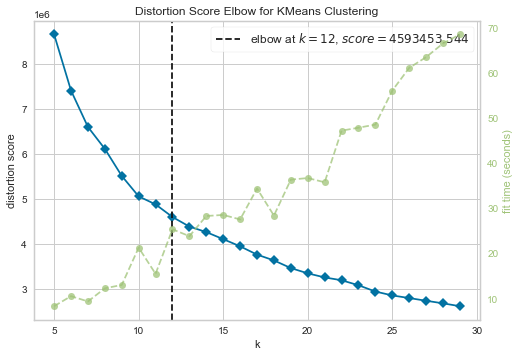

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,30))

visualizer.fit(data_pc.iloc[:,0:7])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


> Second Method is based using Calinski-Harabasz score to find the optimal Clusters.

> We iterate over the possible ranges of K from 5 to 30 and use scikit-learn kmeans to evaluate the different clusters formed for different K.

>The Calinski-Harabasz is the ratio of the sum of *between-clusters dispersion* and of *inter clusters* dispersion for all the clusters computed for a given value of K.

In [103]:
score=[]
for k in tq(range(5, 30)):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(data_pc.iloc[:,0:7])
    labels = kmeans_model.labels_
    sc=metrics.calinski_harabasz_score(data_pc.iloc[:,0:7], labels)
    score.append(sc)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [12:51<00:00, 30.86s/it]


<AxesSubplot:>

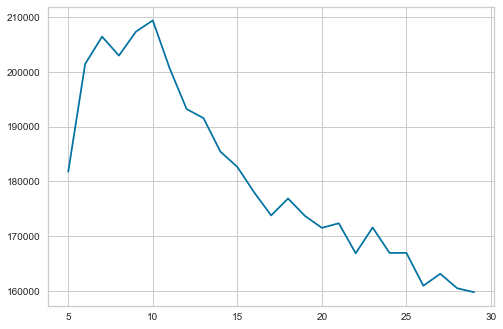

In [105]:
import seaborn as sns
sns.lineplot(x=range(5, 30),y=score)

### Choosing between Elbow method and Calinski-Harabasz score:

> Elbow method faces disadvantages as the main idea behind Elbow methods is to find the number of clusters which minimizes the cost function of the Kmeans i.e the sum of the distance square from it's respective centroid. We then iterate over the different values of K and calculate the cost function value.

>> Further, we look for that part of the curve where the decrease in the cost function is quite small(rate of change) and assume the first value of K where this behaviour is seen. 

>Elbow method is not very precise and reliable in the sense it might overestimate the number of clusters required as increasing the number of clusters our cost function always decreases.

>Hence we should use some other metrics which uses other characteristics of the cluster's (for eg. distance between different clusters)

>Since Calinski-Harabasz score accounts both inter and intra clusters dispersion,we feel that using optimal K suggestion from Calinski-Harabasz score would be more reliable.

## Implementing K-means using Map reduce

In [108]:
##Setting up pyspark
conf = pyspark.SparkConf()
spark=SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext
## Reading the stored Principal Components for the dataset.
df=spark.read.csv('Data_PC.csv')

In [109]:
## Retrieving the data from the dataframe
points=df.collect()

In [114]:
##Retrieving the data of first seven principal components for each customer(these seven principal components explain about 
##72.3% of the variance)
coord=[]
###iterating over the points data
for i,row in enumerate(points):
    if i!=0:
        coord.append(tuple([eval(row[j]) for j in range(1,8)])) ##Getting the first seven principal components 
##Converting list to RDD object     
coord=sc.parallelize(coord)

In [120]:
coord.count()

879358

In [115]:
## Random Intialisation of Centroids for Kmeans
def intial_centroid(coord,k):
    
    """"
    input:coord:RDD object: It contains the the coordinates mapped on the space defined by the seven principal components
          k:Integer:The number of centroids that need to be intialise
    objective:It performs the random intialisation of the required number of centroids.
    returns:centroids: List: Containig the k centroids.
    
    """""
    centroids=[]
    counter=1
    
    ## Random sample k numbers between 1 and total numer of samples(customers) present in coord
    index=random.sample(range(1,coord.count()),k)

    for i in range(k):
        
        ## Based on the randomly sample number retrieve the coordinates for those randomly sampled customers
        centroids.append(tuple([coord.take(index[i])[index[i]-1],counter]))
        
        counter +=1
    return centroids
        
        


In [116]:
## Distance between two points
def distance(c1,c2):
    """"
    input:c1:A tuple: Containing the coordinates information of point A
          c2:A tuple: Containing the coordinates information of point B
    objective:It computes the distance between two points
    returns:float: distance between two points
    
    """""
    dist=0
    for i in range(len(c1)):
        dist+=(c1[i]-c2[i])**2
    return math.sqrt(dist)


In [117]:
## Computing the closest Centroid:
def best_centroid(centroids,point):
    """"
    input:centroid:A tuple: ((x1,x2,x3...),1) This contains the coordinates of the centroids and it's index
          c2:A tuple: Containing the coordinates information of point 
    objective:It computes the index of the centroid which is closest to the point.
    returns:Integer:index of centroid.
    
    """""
    
    dist=100000000

    best_centroid=0
    
    for centroid in centroids:
        dist_cent=distance(centroid[0],point) ## Calculating distance between point and centroid
        ## if the distance is smaller than the minimum distance calulcated till now,update the smallest distance and 
        ##index of the centroid it's closest two
        if dist_cent<dist: 
            dist=dist_cent
            best_centroid=centroid[1] ## The index of the closest centroid

    return best_centroid

In [111]:
## Adding two points(used in Reduced Step)
def sum_points_centroid(p1,p2): ### ###[,1]
    """"
    input:p1:list: [(x1,x2,x3...),s] This contains the coordinates of the point(which is a sum of coordinates of points 
                        belonging the same cluster followed by the number of points that have been used till now 
                        to get the coordinates
          p2:list: [(y1,y2,y3...),t] This contains the coordinates of the point(which is a sum of coordinates of points 
                        belonging the same cluster followed by the number of points that have been used till now 
                        to get the coordinates
    objective:The main objective of the fuction is to add two points information which would we used to compute the final centroid.
            So we need to keep track of the sum of coordinates and total number of points belonging in the cluster
    returns:A list:[(x1+y1,x2+y2,x3+y3,...),s+t]
    
    """""
    
    sum_coord=tuple([sum(x) for x in zip(p1[0],p2[0])])  ###(x1+y1,x2+y2,x3+y3,...)
    sum_points=p1[1]+p2[1]  ## s+t
    return [sum_coord,sum_points] ###

In [112]:
## This would be used for sorting a list of computed new_centroids based on the index of the cluster
def sort_func(x):
    return x[1]

In [118]:
## We first convert every point(customer) into [(x1,x2,x3...x7),1]. This is done with the motivation that during the reduce step
## we are able to keep track of number of points belonging the cluster
points_key=coord.map(lambda x:[x,1])
## Since these points would be used every iteration so we push the data into cache which helps in faster operations(they don't
## collected every map or reduce step is called)
points_key.cache()


PythonRDD[14] at RDD at PythonRDD.scala:53

In [121]:
### defining the threshold between updated and old centroids. If the distance between them is less than 0.001 we assume that 
### centorids have converged
threshold=0.001

### Number of Maximum iteration to run K-means
max_iter=100

##intialising the centroids
cent=intial_centroid(coord,10)


for i in tq(range(max_iter)):
    ## In map step we map all the points to it's closest centroid
    map_points=points_key.keyBy(lambda x:best_centroid(cent,x[0]))
    
    ## In reduced step we sum all the points information belong to specific clusters.So in the end we sum all coordinates and
    ## get the total number of points used to get the sum
    reduced_points=map_points.reduceByKey(lambda a,b:sum_points_centroid(a,b))
    
    ## retrieve the points from reduced step
    reduced_points=reduced_points.collect()
    
    ### Getting the new centroid
    new_cent=[]
    for row in reduced_points:
        index=row[0]
        ##dividing the sum of coordinates with total number of points to get the updated coordinates of new centroid
        new_index_coord=tuple(map(lambda x:x/row[1][1],row[1][0]))
        new_cent.append(tuple([new_index_coord,index]))
    
    ###sorting the updates centroid based on the index of the centroid
    new_cent.sort(key=myfunc)

    ## Checking for convergence
    convergedCentroids = 0
    
    for index, centroid in enumerate(cent):
            dist = distance(centroid[0], new_cent[index][0])

            if dist < threshold:
                    convergedCentroids+=1
    
    cent = new_cent
    
    ## If 90% of the centroids have converged (the distance between old and updated centroid is less than threshold),we assume
    ## k-means have converged.
    percentage = len(cent) * 90 / 100

    if convergedCentroids > percentage:
            print("Centroids converged")
            break
    


[544243, 206136, 113907, 86108, 860835, 505467, 442881, 466936, 389235, 474420]


 50%|████████████████████████████████████████▌                                        | 50/100 [15:13<15:13, 18.27s/it]

Centroids converged


In [122]:
## Getting the centroid index for each of the customers based on the centroid obtained from k-means.
data_pc['Cent_kmeans']=data_pc.apply(lambda x: best_centroid(cent,x.values),axis=1)


### Visualising the clusters from k-means

<IPython.core.display.Javascript object>


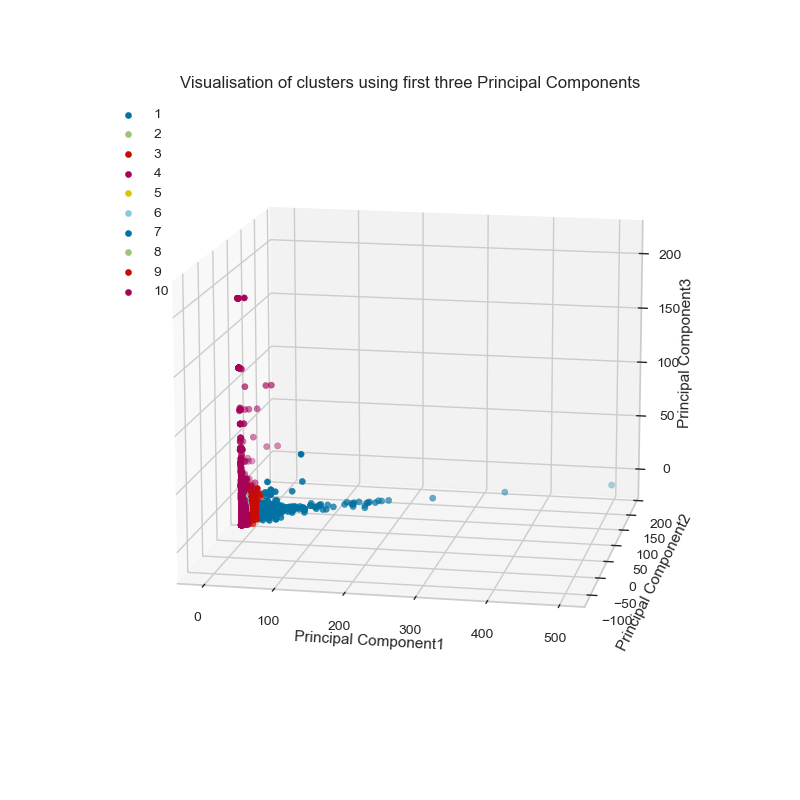

In [131]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(projection='3d')

#1 - Looping Through Group Information
for grp_name, grp_idx in data_pc.groupby('Cent_kmeans').groups.items():
    x = data_pc.loc[grp_idx, 'Principal Component1']
    y = data_pc.loc[grp_idx, 'Principal Component2']
    z = data_pc.loc[grp_idx, 'Principal Component3']
    axes.scatter(x, y, z, label=grp_name, s=20)
#2 - Adding The Legend To The Axes Object
axes.legend(loc='upper left')
axes.set_title("Visualisation of clusters using first three Principal Components")
axes.set_xlabel('Principal Component1')
axes.set_ylabel('Principal Component2')
axes.set_zlabel('Principal Component3')
plt.show()

### Now we go for K-means ++ 

In [132]:
## Performing k-means++ using scikit-learn methods.
kmeans = KMeans(n_clusters=10, random_state=0,init='k-means++').fit(data_pc.iloc[:,0:7])

In [133]:
cent_2=kmeans.cluster_centers_ ### Centroids from kmeans++

## Adding the index of the centroid for all the obtained centroids 
cent_plus=[]
for i in range(len(cent_2)):
    cent_plus.append((tuple(cent_2[i]),i+1))

data_pc['Cent_plus']=data_pc.apply(lambda x: best_centroid(cent_plus,x.values[0:7]),axis=1)

### Visualising the clusters from K-means ++

<IPython.core.display.Javascript object>


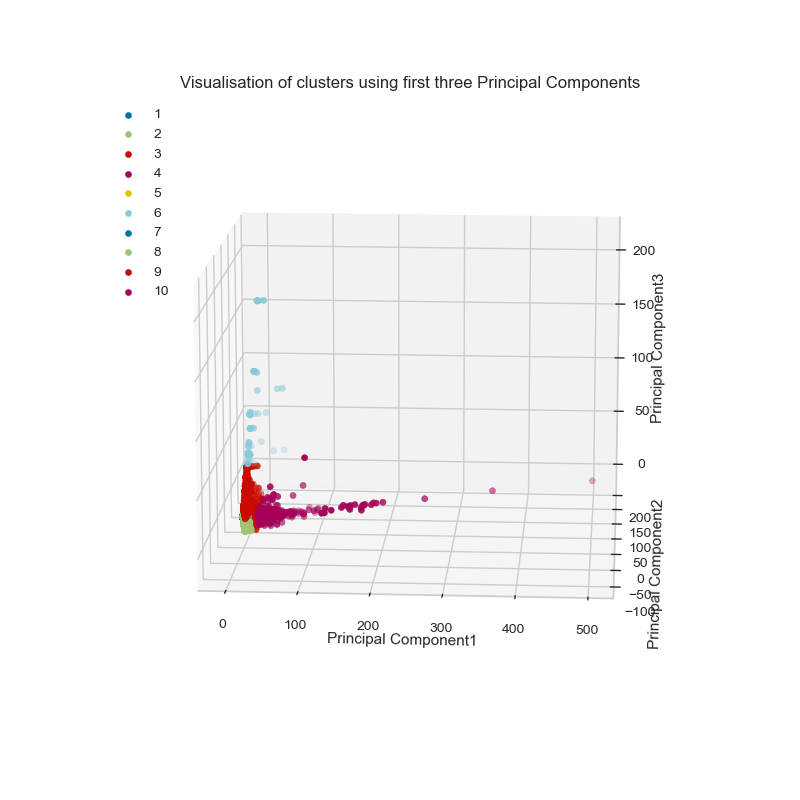

In [136]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(projection='3d')

#1 - Looping Through Group Information
for grp_name, grp_idx in data_pc.groupby('Cent_plus').groups.items():
    x = data_pc.loc[grp_idx, 'Principal Component1']
    y = data_pc.loc[grp_idx, 'Principal Component2']
    z = data_pc.loc[grp_idx, 'Principal Component3']
    axes.scatter(x, y, z, label=grp_name, s=20)
#2 - Adding The Legend To The Axes Object
axes.legend(loc='upper left')
axes.set_title("Visualisation of clusters using first three Principal Components")
axes.set_xlabel('Principal Component1')
axes.set_ylabel('Principal Component2')
axes.set_zlabel('Principal Component3')
plt.show()

### Comparing results between K-means and K-means ++ using David Bouldin Score

In [151]:
## For k-means
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_kmeans'])

1.6750654806510936

In [153]:
## For k-means++
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_plus'])

0.8820889631569759

> We notice that we get lower David Bouldin Score for K-means++ than K-means.

> David Bouldin Score in broad terms is the ratio of how spread the clusters(cluster scatter) and the different cluster's seperation.So lower David Bouldin Score conveys better seperation between the Cluster.

> Hence based on DB score we infer that cluster obtained are more optimal than k-means.

In [127]:
df_reduced_stand=pd.DataFrame(data=data_reduced_stand,columns=data_reduced.columns)
df_reduced_stand['Cent_kmeans']=data_pc['Cent_kmeans']
##Storing the results obtained from K-means that would be used in section 2.4
df_reduced_stand.to_csv('Dataset_centroid_standard.csv')

# 2.4 Analysing your results!

In [166]:
df_reduced_stand

,NumTransactions,NumTransactions_100,AvgTransactions,AvgBalance,AvgUtilisation,Gender,Location,MinTransaction,MaxTransaction,NumTransactions_10000,...,MaxAge,NumTransactions_40,Transaction_part_day,MdnBalance,Balance_greater_100k,Tr_B_ratio,Number_Locations,Average_amount_location,Trans_morn_afternoon,Cent_kmeans
0,1.816408,1.909856,0.153298,-0.047903,-0.049156,1.544647,-0.383099,-0.163137,0.418180,-0.158192,...,0.149629,-0.369014,0.669300,-0.046098,0.854602,-0.024242,1.816408,-0.025259,0.734732,2
1,-0.410992,0.125094,-0.010538,-0.112985,-0.112950,-0.647397,-0.379688,0.019943,-0.039223,-0.158192,...,-1.054080,-0.369014,0.669300,-0.111355,-0.465441,-0.024169,-0.410992,0.010193,-0.185294,3
2,1.816408,1.909856,-0.130462,-0.018228,-0.017188,1.544647,-0.379688,-0.180115,-0.080588,-0.158192,...,0.040201,-0.369014,0.148647,-0.016343,0.854602,-0.024308,1.816408,-0.170688,0.048102,3
3,-0.410992,-1.659668,-0.238883,-0.142580,-0.140724,1.544647,-0.376277,-0.215354,-0.245906,-0.158192,...,-0.616368,-0.369014,-0.372007,-0.141030,-0.465441,-0.024173,-0.410992,-0.223864,-0.179484,2
4,-0.410992,0.125094,0.533666,-0.034524,-0.038826,-0.647397,-0.372866,0.580714,0.453354,-0.158192,...,2.119336,2.818654,-0.372007,-0.032683,-0.465441,-0.024181,-0.410992,0.568009,0.783154,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879353,-0.410992,0.125094,-0.136136,0.022909,0.024013,-0.647397,-0.106833,-0.109478,-0.152905,-0.158192,...,-0.616368,-0.369014,2.751912,0.024904,2.174646,-0.024313,-0.410992,-0.118547,-0.185294,6
879354,-0.410992,0.125094,-0.209038,-0.023283,-0.021614,-0.647397,-0.362634,-0.184600,-0.218892,-0.158192,...,-1.272936,-0.369014,-1.413313,-0.021412,-0.465441,-0.024321,-0.410992,-0.193273,-0.142295,8
879355,-0.410992,0.125094,-0.223961,-0.136260,-0.134520,-0.647397,0.411592,-0.199977,-0.232399,-0.158192,...,-0.944652,-0.369014,-1.413313,-0.134692,-0.465441,-0.024269,-0.410992,-0.208569,-0.160889,5
879356,-0.410992,-1.659668,-0.235774,-0.099140,-0.097289,-0.647397,-0.311474,-0.212150,-0.243092,-0.158192,...,-1.163508,-0.369014,0.669300,-0.097472,-0.465441,-0.024323,-0.410992,-0.220678,-0.185294,5


In order to build the requested pivot tables, we choose the 3 variables that in our opinion better identify the cluster of the customer:
- **AvgUtilisation**
- **Recency**
- **AvgAge**

### AvgUtilisation

> It represents the average difference between the balance and the transaction amount for each customer

In [167]:
df_reduced_stand.AvgUtilisation.describe()

count    8.793580e+05
mean     5.330086e-17
std      1.000001e+00
min     -2.036506e+00
25%     -1.353698e-01
50%     -1.193897e-01
75%     -6.661108e-02
max      1.435196e+02
Name: AvgUtilisation, dtype: float64

In [169]:
quant = np.quantile(df_reduced_stand['AvgUtilisation'], q=[0, 0.25, 0.5, 0.75, 1])
print(quant)

[-2.03650608e+00 -1.35369819e-01 -1.19389672e-01 -6.66110797e-02
  1.43519638e+02]


So, our four categories will be:
- **1** : $[0, 0.25]$ -> $[-2.038, -0.135]$
- **2** : $[0.25, 0.5]$ -> $[-0.135, -0.119]$
- **3** : $[0.5, 0.75]$ -> $[-0.119, -0.0666]$
- **4** : $[0.74, 1]$ -> $[-0.0666, 143.52]$

In [171]:
df_reduced_stand['AvgUtilisation_c'] = pd.cut(df_reduced_stand['AvgUtilisation'], quant, include_lowest = True)

In [172]:
round(pd.crosstab(index = df_reduced_stand['Cent_kmeans'], columns=df_reduced_stand['AvgUtilisation_c'] , normalize='index', margins=True, margins_name='Total')*100,2)

AvgUtilisation_c,"(-2.038, -0.135]","(-0.135, -0.119]","(-0.119, -0.0666]","(-0.0666, 143.52]"
Cent_kmeans,,,,
1,35.74,0.70,20.72,42.84
2,16.25,18.47,23.73,41.56
3,29.36,30.50,27.79,12.36
4,14.77,16.98,24.48,43.76
5,30.83,28.66,26.21,14.29
6,14.04,13.93,19.56,52.47
7,35.77,28.51,23.99,11.72
8,31.08,32.12,26.28,10.52
9,32.84,7.29,14.22,45.65


From the pivot table table we can see that Cluster 1, 2, 4, 6 and 9 have values of Average Utilisation mostly condensated after the fourth quantile, with an avarage of about 45.2%. Similarly, Cluster 10 customers are only distributed in the same category. The other Clusters are more or less equally distributed in all the 4 categories.

### Recency

> It represents in which part of the year (in days) the customers usually do their transactions

In [173]:
df_reduced_stand.Recency.describe()

count    8.793580e+05
mean     3.688990e-16
std      1.000001e+00
min     -1.669434e+00
25%     -8.416979e-01
50%     -1.396156e-02
75%      7.447967e-01
max      3.917786e+00
Name: Recency, dtype: float64

Again, as a first thing we divide the variable into 4 categories

In [174]:
quant = np.quantile(df_reduced_stand['Recency'], q=[0, 0.25, 0.5, 0.75, 1])
print(quant)

[-1.66943424 -0.8416979  -0.01396156  0.74479675  3.91778604]


The four categories based on the quantils will be:
- **1** : $[0, 0.25]$ -> $[-1.67, -0.842]$
- **2** : $[0.25, 0.5]$ -> $[-0.842, -0.014]$
- **3** : $[0.5, 0.75]$ -> $[-0.014, 0.745]$
- **4** : $[0.74, 1]$ -> $[0.745, 3.918]$

In [176]:
df_reduced_stand['Recency_c'] = pd.cut(df_reduced_stand['Recency'], quant, include_lowest = True)

In [177]:
round(pd.crosstab(index = df_reduced_stand['Cent_kmeans'], columns= df_reduced_stand['Recency_c'] , normalize='index', margins=True, margins_name='Total')*100,2)

Recency_c,"(-1.67, -0.842]","(-0.842, -0.014]","(-0.014, 0.745]","(0.745, 3.918]"
Cent_kmeans,,,,
1,23.52,28.06,21.07,27.36
2,0.00,0.00,27.40,72.60
3,81.16,13.30,5.54,0.00
4,23.59,27.98,25.67,22.76
5,8.67,61.72,29.61,0.00
6,43.70,42.78,13.49,0.03
7,28.79,28.86,27.21,15.15
8,0.00,0.10,37.70,62.20
9,26.62,25.80,23.50,24.09


From the table we can see that in Cluster 2 and 8 the Recency values are mostly distributed in the last two categories (72.6% and 62.2% respectively), so between the 3rd and 4th quantile, but with the majority in the 4th. Simirarly, in Cluster 5 the values are condensated between the 2nd and 3rd categories (2nd and 3rd qualtiles), but with the majority of them being in the 2nd category (61.7%). Cluster 3 has the majority of customers distributed in the first category (1st quantile, with a percentage of 81%), while Cluster 6 has the highest number of costumers distributed between the 1st and 2nd category (43.7% and 42.7% respectively). In the rest of the Clusters the values are equally distributed between the 4 categories.

In [178]:
df_reduced_stand.AvgAge.describe()

count    8.793580e+05
mean    -6.547782e-17
std      1.000001e+00
min     -1.766953e+00
25%     -5.755083e-01
50%     -2.180747e-01
75%      3.776479e-01
max      1.002835e+01
Name: AvgAge, dtype: float64

In [179]:
quant = np.quantile(df_reduced_stand['AvgAge'], q=[0, 0.25, 0.5, 0.75, 1])
print(quant)

[-1.76695347 -0.57550826 -0.21807469  0.37764791 10.0283541 ]


In [180]:
df_reduced_stand['AvgAge_c'] = pd.cut(df_reduced_stand['AvgAge'], quant, include_lowest = True)

In [182]:
round(pd.crosstab(index = df_reduced_stand['Cent_kmeans'], columns= df_reduced_stand['AvgAge_c'] , normalize='index', margins=True, margins_name='Total')*100,2)

AvgAge_c,"(-1.7679999999999998, -0.576]","(-0.576, -0.218]","(-0.218, 0.378]","(0.378, 10.028]"
Cent_kmeans,,,,
1,9.66,37.72,12.11,40.51
2,16.81,24.13,32.12,26.94
3,41.72,28.81,22.85,6.62
4,0.00,0.06,1.74,98.20
5,44.25,28.48,20.98,6.29
6,13.74,24.14,31.76,30.37
7,0.00,0.02,11.98,88.00
8,48.50,28.71,18.99,3.80
9,13.52,26.03,19.76,40.69


From the table we can notice that in Cluster 4, 7 and 10 the customers Avg Age is highly condensated in the 4th category, with an average of 84.8%. In Cluster 1 the customers are distributed between the 2nd and 4th category (37.7% and 40.5% respectively), while in Cluster 3, 5 and 8 customers are mostly distributed in the 1st category, with an average of 44.8%. In the rest of Clusters customers are more or less equally distributed between the 4 categories. 

### Evaluation of the clustering algorithm performance

We used David-Bouldin score to measure the performace of the K-means clustering algorithm which is based on the idea of computing the average similarity measure of each cluster with it's most similar cluster. If the clusters are well seperated and less-spread we expect to have lower DB score.

In [203]:
## For k-means
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_kmeans'])

1.6750654806510936

We notice that for K-means we get quite high score,which shows that clusters are not very well seperated and are quite spread across the space formed by the seven principal components.On other hand K-means++ recieves a better score(0.88) than it's counterpart due to fact of better intialisation of the K-centroids.

## Bonus Part

> Here we have attempted to use one-more clustering algorithm-Bisecting K-means

In [162]:
Bkmeans = BKMeans(n_clusters=10, random_state=0,init='k-means++').fit(data_pc.iloc[:,0:7])

In [164]:
cent_3=kmeans.cluster_centers_ ### Centroids from kmeans++

## Adding the index of the centroid for all the obtained centroids 
cent_bk=[]
for i in range(len(cent_2)):
    cent_bk.append((tuple(cent_3[i]),i+1))

data_pc['Cent_BK']=data_pc.apply(lambda x: best_centroid(cent_bk,x.values[0:7]),axis=1)

In [165]:
## For k-means++
metrics.davies_bouldin_score(data_pc.values[:,0:7],labels=data_pc['Cent_BK'])

0.891399219375456

Comparison:
        
> K-means: 1.6750654806510936

> K-means++: 0.8820889631569759

> Bisecting K-means: 0.891399219375456

> For the three clustering algorithm we see that K-means++ has the least David-Bouldin Score.Since all these three are based on minimising the same cost function,they have slight variation in implementation.

>K-means++ does not use random intialisation instead the points are picked based on probability(proportional to the distance from the centroid). First centroid is randomly picked after which all the other points in the space have probability attached to it for being picked up as an centroid.

>Bisecting-Kmeans: It's a modified version of K-means which is an overlap of partition and hierarchical based clustering. It start's with considering the whole data as one cluster and then bisects the data into two parts resulting in two centroids.This process is continued until K clusters have been formed. This is computational more effective as compared to k-means as each stage it does not consider all the points for calculation of the centroid.

>Based,on David Bouldin score we infer that K-means++ is a better performing algorithm due to the fact of choosing intial centroids in a reliable way.


# Algorithmic question

As a first thing, we take in input from the user the required values as integers: M students, N entrances and G guards. <br /> We take in input from the user also the list "order", which contains M integers, where the ith integer corresponds to the entrance that has been assigned to the i-th student to enter the university.

<center> 1 $\le$ N $\le$ $10^6$ <br />
1 $\le$ M $\le$ $10^3$ <br />
1 $\le$ G $\le$ 100 </center>

## Input-1

In [205]:
M=int(input()) ## Number of gates
N=int(input()) ## Number of students
G=int(input()) ## Gaurds


## Order of the students
order = []
for i in range(N):
        order.append(int(input()))
          


2
6
3
1
1
2
2
1
2


In [206]:
gaurds_on_duty=[]
for i in range(len(order)):
    ## Check if there are more gaurds available for new gates encountered in the orders.Or if the gate has already a gaurd,the
    ## student would enter with proper protocol
    
    try:
        assert(len(order)==N)
    except:
        print('The order does not correspond to the number of students')
    
    if (len(gaurds_on_duty)<G) or (order[i] in gaurds_on_duty):
        
        ## Give free gaurds new gates(by checking if the already an gaurd is not present at that gate)
        if order[i] not in gaurds_on_duty:
            
            gaurds_on_duty.append(order[i])
        ## If there is no more students using that gate,the gaurd is made free form the position and is ready to be assigned to the 
        ##the new gate
        if order[i] not in order[i+1:len(order)+1]:
            ##Free gaurd
            gaurds_on_duty.remove(order[i])
        ## If all the gates had gaurd during the student arrival,we successfully managed to apply restrictions
        if i==len(order)-1:
            print('YES')
    else:
        print('NO')
        break

YES


The solution will output “YES” if having G guards is enough to respect the restrictions, and “NO” if it is not enough. <br /> In this case 3 guards are enough to handle the restrictions.

## Input 2

In [208]:
M=int(input()) ## Number of gates
N=int(input()) ## Number of students
G=int(input()) ## Gaurds


## Order of the students
order = []
for i in range(N):
        order.append(int(input()))
          


3
15
1
1
1
3
2
2
2
3
3
3
1
2
3
2
1
1


In this example we take in input 3 gates, 15 students, 1 guard, and the order list is composed by 15 integers, the same number of students. 

In [209]:
gaurds_on_duty=[]
for i in range(len(order)):
    ## Check if there are more gaurds available for new gates encountered in the orders.Or if the gate has already a gaurd,the
    ## student would enter with proper protocol
    
    try:
        assert(len(order)==N)
    except:
        print('The order does not correspond to the number of students')
    
    if (len(gaurds_on_duty)<G) or (order[i] in gaurds_on_duty):
        
        ## Give free gaurds new gates(by checking if the already an gaurd is not present at that gate)
        if order[i] not in gaurds_on_duty:
            
            gaurds_on_duty.append(order[i])
        ## If there is no more students using that gate,the gaurd is made free form the position and is ready to be assigned to the 
        ##the new gate
        if order[i] not in order[i+1:len(order)+1]:
            ##Free gaurd
            gaurds_on_duty.remove(order[i])
        ## If all the gates had gaurd during the student arrival,we successfully managed to apply restrictions
        if i==len(order)-1:
            print('YES')
    else:
        print('NO')
        break

NO


The output is output “NO”, so having 1 guard it is not enough to handle the restrictions.